In [313]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import torch
import torch.nn as nn
from torch.nn import functional as F
from itertools import groupby
from operator import itemgetter
import datetime
import math
import pandas as pd
import numpy as np
import pytz

file1 = "all_training_data_sorted.csv"
north = 'data_north_p.csv'
east = 'data_east_p.csv'
south = 'data_south_p.csv'
west = 'data_west_p.csv'
device = 'cuda'

tz = pytz.timezone('Europe/Berlin')

def convert_to_weeknumber_cossin(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp)
    dt_local = date.astimezone(tz)
    week_number = dt_local.isocalendar()[1]
    sin_week = np.sin(2*np.pi*week_number/53).astype(np.float32)
    cos_week = np.cos(2*np.pi*week_number/53).astype(np.float32)
    return sin_week, cos_week

def convert_to_hour_cossin(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp)
    dt_local = date.astimezone(tz)
    hour = dt_local.hour
    sin_hour = np.sin(2*np.pi*hour/24).astype(np.float32)
    cos_hour = np.cos(2*np.pi*hour/24).astype(np.float32)
    return sin_hour, cos_hour


def closest_timestamp(data, timestamp):
    closest_timestamp = min(data.keys(), key=lambda t: abs(t - timestamp))
    return data[closest_timestamp]

def read_csv(file):
    data = pd.read_csv(file)
    for index, row in data.iterrows():
        yield row['time'] / 1_000_000_000, row['tags'], row['min'], row['max'], row['mean'] 

def read_csv_meteostat(file):
    data = pd.read_csv(file)
    timestamp_dict = {}
    for index, row in data.iterrows():
        if not pd.isna(row['time']) and not pd.isna(row['pres']):
            timestamp = row['time'] / 1_000_000_000
            timestamp_dict[timestamp] = row['pres']                            
    return timestamp_dict

def group_column(file, north, east, south, west):
    meteostat_data_north = read_csv_meteostat(north)
    meteostat_data_east = read_csv_meteostat(east)
    meteostat_data_south = read_csv_meteostat(south)
    meteostat_data_west = read_csv_meteostat(west)
    
    for timestamp, values in groupby(read_csv(file), key=itemgetter(0)):
        pres_value_north = closest_timestamp(meteostat_data_north, timestamp)
        pres_value_east = closest_timestamp(meteostat_data_east, timestamp)
        pres_value_south = closest_timestamp(meteostat_data_south, timestamp)
        pres_value_west = closest_timestamp(meteostat_data_west, timestamp)
        
        d = {}
        for (_, topic, value_min, value_max, value_mean) in values:
            if not math.isnan(value_min) and not math.isnan(value_max) and not math.isnan(value_mean):
                d[topic] = {'min': value_min, 'max': value_max, 'mean': value_mean}
        
        try:
            week_values = convert_to_weeknumber_cossin(timestamp)
            hour_values = convert_to_hour_cossin(timestamp)
            yield (
                (d["topic=Pfullingen/temperature"]['mean'] - 20) / 35, 
                (d["topic=Pfullingen/hourlyrain"]['mean']) / 10, 
                (d["topic=Pfullingen/windspeed"]['mean']- 5) / 10,
                (d["topic=Pfullingen/solarradiation"]['max'] - 500) / 1000,
                (d["topic=Pfullingen/solarradiation"]['mean'] - 500) / 1000, 
                (d["topic=Pfullingen/pressure"]['mean'] - 500) / 1000,
                (d["topic=Pfullingen/winddir"]['mean'] - 180) / 360,
                (d["topic=Pfullingen/humidity"]['mean'] - 50) / 100,
                hour_values[0],
                hour_values[1],
                week_values[0],
                week_values[1],
                float((pres_value_north - 500) / 1000),
                float((pres_value_east - 500) / 1000),
                float((pres_value_south - 500) / 1000),
                float((pres_value_west - 500) / 1000)
                
            )
        except KeyError:
            pass

In [505]:
imported_data_raw = list(group_column(file1, north, east, south, west))
imported_data_backup = torch.tensor(imported_data_raw)

In [530]:
imported_data = imported_data_backup.clone()

In [531]:
imported_data[:, 12] -= imported_data[:, 5]
imported_data[:, 13] -= imported_data[:, 5]
imported_data[:, 14] -= imported_data[:, 5]
imported_data[:, 15] -= imported_data[:, 5]

imported_data[:, 12] *= 45
imported_data[:, 13] *= 45
imported_data[:, 14] *= 45
imported_data[:, 15] *= 45

In [537]:
imported_data[:, 15].min()

tensor(-0.7129)

In [538]:
imported_data.shape

torch.Size([18664, 16])

In [603]:
input_hours = 72
features = 16

In [604]:
def create_sequences(data, input_hours, features):
    xs = []
    ys = []

    for i in range(data.size(0)-input_hours-1):
        x = data[i:(i+input_hours)]
        y = data[i+input_hours]
        xs.append(x)
        ys.append(y)

    return torch.stack(xs).view(-1,input_hours*features), torch.stack(ys)


In [605]:
X, y = create_sequences(imported_data, input_hours, features)

In [606]:
print("X.shape: ",X.shape)
print("y.shape: ",y.shape)

X.shape:  torch.Size([18591, 1152])
y.shape:  torch.Size([18591, 16])


In [607]:
from torch.utils.data import random_split
from torch.utils.data import TensorDataset, DataLoader

# Calculate split sizes
num_samples = len(X)
num_train = round(num_samples * 0.8)
num_val = num_samples - num_train

# Create data sets
train_data, val_data = random_split(TensorDataset(X, y), [num_train, num_val])

batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [648]:
class model_linear(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim*2, bias=True)
        self.norm1 = nn.BatchNorm1d(hidden_dim*2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(hidden_dim*2, hidden_dim, bias=True)
        self.norm2 = nn.BatchNorm1d(hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.dropout1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = self.layer3(x)
        return x



In [649]:
input_dim = features*input_hours
hidden_dim = 32
output_dim = features

model = model_linear(input_dim, hidden_dim, output_dim).to(device)

In [650]:
for inputs, labels in train_loader:
    print(inputs.shape, labels.shape)
    break

torch.Size([32, 1152]) torch.Size([32, 16])


In [ ]:
num_epochs = 30
criterion = nn.MSELoss()#L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(num_epochs*.6), gamma=0.1)
model.dropout1.p = 0.2

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for inputs, labels in train_loader:
        inputs = inputs.view(batch_size, input_hours * features)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        train_losses.append(loss.item())
        optimizer.step()

    avg_train_loss = sum(train_losses) / len(train_losses)
    scheduler.step()
    model.eval()
    with torch.no_grad():
        val_losses = []
        for inputs, labels in val_loader:
            inputs = inputs.view(batch_size, input_hours * features)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
    #best so far 0.0029 MSELoss
    

In [678]:
file1_forecast = "test_sorted.csv"
north_forecast = 'data_north_p_test_latest.csv'
east_forecast = 'data_east_p_test_latest.csv'
south_forecast = 'data_south_p_test_latest.csv'
west_forecast = 'data_west_p_test_latest.csv'

In [693]:
file1_forecast = "test_before_coldfront_sorted.csv"
north_forecast = 'data_north_p_test_latest_before_coldfront.csv'
east_forecast = 'data_east_p_test_latest_before_coldfront.csv'
south_forecast = 'data_south_p_test_latest_before_coldfront.csv'
west_forecast = 'data_west_p_test_latest_before_coldfront.csv'

In [694]:
test_data_raw = list(group_column(file1_forecast, north_forecast, east_forecast, south_forecast, west_forecast))
test_data = torch.tensor(test_data_raw, device=device)
eval_data = test_data[-input_hours:,:].view(1,-1)
eval_data.shape

torch.Size([1, 1152])

In [695]:
import torch

def generate_data(model, initial_data, steps):
    model.eval()  # Ensure the model is in evaluation mode
    generated_data = []

    current_input = initial_data

    with torch.no_grad():  # We don't need gradients for this
        for _ in range(steps):
            output = model(current_input)

            # Add the output to our list of generated data
            generated_data.append(output)

            # Now we need to append the output to the input data
            # We will remove the first output dimension from the input 
            # and append the new output to the end
            current_input = torch.cat((current_input[:, output.shape[1]:], output), dim=1)

    return torch.stack(generated_data).view(steps,features)

In [700]:
forecast = generate_data(model, eval_data, steps=24)
forecast.shape

torch.Size([24, 16])

In [701]:
input_temperature = eval_data.view(input_hours,features)[:,0]*35+20
temperature = forecast[:,0]*35+20
sun_max = forecast[:,3]*1000+500
sun_mean = forecast[:,4]*1000+500
sine = forecast[:,8]
pres_diff = forecast[:,12]
forecast_temperature = temperature.cpu().detach().numpy()
input_temperature = input_temperature.cpu().detach().numpy()
sine = sine.cpu().detach().numpy()
pres_diff = pres_diff.cpu().detach().numpy()
sun_max = sun_max.cpu().detach().numpy()
sun_mean = sun_mean.cpu().detach().numpy()

Text(0, 0.5, 'Temperature')

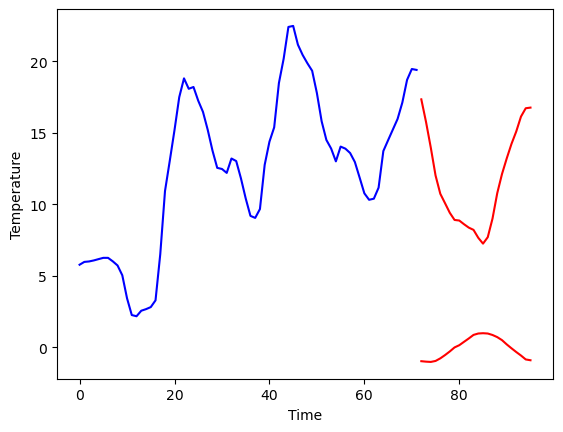

In [702]:
import matplotlib.pyplot as plt
# Generate x-axis values for the plots
x_input = range(len(input_temperature))
x_forecast = range(len(input_temperature), len(input_temperature) + len(forecast_temperature))
plt.plot(x_input, input_temperature, color='blue', label='Input Temperature')
plt.plot(x_forecast, forecast_temperature, color='red', label='Forecast Temperature')
plt.plot(x_forecast, sine, color='red', label='sine')
#plt.plot(x_forecast, sun_max, color='red')
#plt.plot(x_forecast, sun_mean, color='red')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Temperature')

In [699]:
temperature

tensor([17.3390, 15.7463, 13.9590, 12.0160, 10.7376, 10.0770,  9.4094,  8.9097,
         8.8677,  8.6096,  8.3729,  8.2153,  7.6613,  7.2529,  7.7048,  9.0047,
        10.7842, 12.1213, 13.2148, 14.2274, 15.0918, 16.1355, 16.7170, 16.7614,
        15.9245, 14.9026, 13.6265, 11.7239, 10.6657,  9.6601,  8.8198,  8.3698,
         8.1420,  7.5346,  7.0384,  6.5721,  5.9149,  5.6914,  5.8244,  6.8307,
         8.4529, 10.3341, 12.5905, 14.4268, 15.8041, 16.5504, 17.2494, 17.6173],
       device='cuda:0')